In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # model split
import tensorflow as tf #tensorflow
from sklearn.feature_extraction.text import CountVectorizer #
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn.metrics import accuracy_score , roc_auc_score , confusion_matrix

In [2]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

In [3]:
# ฟังก์ชันเปลี่ยนเวลาที่เป็น string เป็น Datetime
from datetime import datetime
def changetime(row):
    if type(row) == float:
        return datetime.strptime('2000-01-01 0:0:0','%Y-%m-%d %H:%M:%S')
    ymdstr = row.split()[0]
    t = row.split()[1].split('.')[0]
    ymdstr+=' '+t
    return  datetime.strptime(ymdstr,'%Y-%m-%d %H:%M:%S')

In [4]:
restuarants = pd.read_csv('restaurants.csv')
transac = pd.read_csv('transactions.csv')
users = pd.read_csv('user_stats.csv')

In [5]:
# ให้ transac_dt แทน dataframe  ของ transac ที่มีการเพิ่ม feature df_createtime ซึ่งเป็น 
# สิ่งเดียวกับ createtime แต่เป็น type datetime
transac_dt = transac.copy()
transac_dt['df_createtime'] = transac.created_at.map(changetime)
transac_dt['weekday'] = transac.created_at.map(changetime).map(lambda b:b.day_name())

In [6]:
transac_dt.head()

,transaction_id,created_at,dt,user_id,restaurant_id,status,distance,final_food_price,discount_amount,completed_at,delivery_fee,df_createtime,weekday
0,transaction_433,2021-03-24 13:59:22.877,20210324,user_2018,restaurant_3264,COMPLETED,3963.0,24.0,NaN,2021-03-24 14:33:53.579,26.0,2021-03-24 13:59:22,Wednesday
1,transaction_434,2021-03-24 14:16:58.145,20210324,user_20380,restaurant_2237,COMPLETED,6208.0,117.0,NaN,2021-03-24 14:54:16.406,0.0,2021-03-24 14:16:58,Wednesday
2,transaction_435,2021-03-24 19:24:06.744,20210324,user_18288,restaurant_2108,CANCELED,10991.0,370.0,NaN,NaN,83.0,2021-03-24 19:24:06,Wednesday
3,transaction_436,2021-03-24 21:26:43.362,20210324,user_14421,restaurant_2531,CANCELED,2683.0,200.0,NaN,NaN,0.0,2021-03-24 21:26:43,Wednesday
4,transaction_437,2021-03-24 13:24:49.304,20210324,user_3144,restaurant_649,COMPLETED,2534.0,85.0,50.0,2021-03-24 13:48:12.440,0.0,2021-03-24 13:24:49,Wednesday


In [7]:
transac_dt.isnull().sum() / transac_dt.shape[0]

transaction_id      0.000000
created_at          0.000000
dt                  0.000000
user_id             0.000000
restaurant_id       0.000000
status              0.000000
distance            0.000000
final_food_price    0.000000
discount_amount     0.925324
completed_at        0.112190
delivery_fee        0.000000
df_createtime       0.000000
weekday             0.000000
dtype: float64

discount_amount  มี missing value ถึง 92 % ดังนั้นควรตัดออกจาก columns ไปเลย

# EDA1 : ORDER TIME 
คิดเวลาที่เฉลี่ยที่ user 1 จะสั่งอาหารในครั้งต่อไป หลังจากการสั่งครั้งล่าสุด

In [8]:
dtusercreate = pd.DataFrame(users.created_at.map(changetime))
dtusercreate.columns = ['dtcreate']
dtusercreate['user_id'] = users.user_id
dtusercreate.head()

daydiff = transac_dt[['user_id','df_createtime']].merge(dtusercreate , on = 'user_id').groupby('user_id')[['df_createtime','dtcreate']].max().reset_index()
daydiff['dayfrombegin'] = (daydiff['df_createtime'] - daydiff['dtcreate']).dt.days
daydiff.head()

,user_id,df_createtime,dtcreate,dayfrombegin
0,user_0,2021-03-02 12:00:26,2020-08-18 12:02:03,195
1,user_1,2021-02-28 18:36:53,2017-11-02 00:40:32,1214
2,user_10,2021-03-13 17:42:21,2020-09-25 18:19:57,168
3,user_100,2021-02-23 00:33:43,2020-08-03 11:11:53,203
4,user_1000,2021-01-06 12:24:06,2017-01-12 23:35:18,1454


In [9]:
t_all = transac_dt.groupby('user_id').df_createtime.agg(['max','min','count']).reset_index()

daydiff = transac_dt[['user_id','df_createtime']].merge(dtusercreate , on = 'user_id').groupby('user_id')[['df_createtime','dtcreate']].max().reset_index()
daydiff['dayfrombegin'] = (daydiff['df_createtime'] - daydiff['dtcreate']).dt.days

t_all = t_all.merge(daydiff[['user_id' , 'dayfrombegin']] , on = 'user_id')
t_all['av_day'] = ((t_all['max'] - t_all['min']).dt.days)/(t_all['count'])
t_all['interval'] = ((t_all['max'] - t_all['min']).dt.days)


* dayfrombegin  คือ ตัวแปรที่บอกว่าลูกค้าอยู่กับเรามากี่วันแล้ว
* av_day คือ ระยะเวลาเฉลี่ยระหว่างการสั่ง 2 order ข้อสังเกตคือ มีค่าเป็น 0 ค่อนข้างมาก ดูได้จาก count == 1 หมายความว่า มีลูกค้าหลายคนพึ่งสั่งเป็นครั้งแรก
* interval คือระยะเวลา นับตั้งแต่มีการสั่งorderแรก

<AxesSubplot:xlabel='av_day', ylabel='Density'>

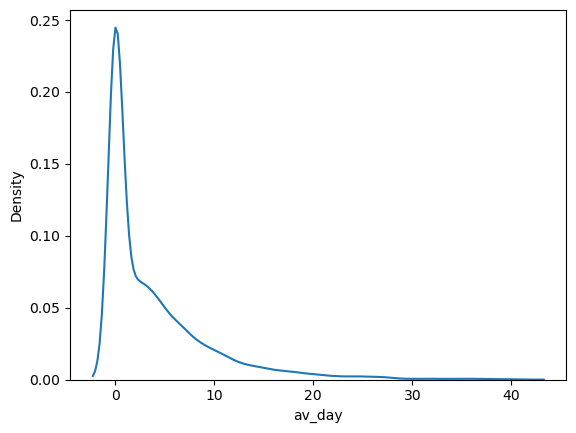

In [10]:
sns.kdeplot(t_all.av_day)

In [11]:
pd.DataFrame(t_all[(t_all['count'] > 1) & (t_all.interval < 7)].av_day.describe()).T

,count,mean,std,min,25%,50%,75%,max
av_day,2716.0,0.707277,0.853938,0.0,0.0,0.5,1.0,3.0


จะเห็นได้ว่า 100% ของคน คนที่สั่งมากกว่า 1 ครั้ง ใน 2 อาทิตย์ จะมีแนวโน้ม ที่จะสั่งอีกครั้ง ใน 4 วัน (0 นับเป็นวันที่ 1) หลังจากออร์เดอร์ล่าสุด

In [12]:
pd.DataFrame(t_all[(t_all['count'] > 1) & (t_all.interval < 14)].av_day.describe()).T

,count,mean,std,min,25%,50%,75%,max
av_day,3950.0,1.517693,1.652809,0.0,0.0,1.0,2.5,6.5


จะเห็นได้ว่า 75% ของคน คนที่สั่งมากกว่า 1 ครั้ง ใน 2 อาทิตย์ จะมีแนวโน้ม ที่จะสั่งอีกครั้ง ใน 2 วัน (0 นับเป็นวันที่ 1) หลังจากออร์เดอร์ล่าสุด

In [13]:
pd.DataFrame(t_all[(t_all['count'] > 1) & (t_all.interval < 30)].av_day.describe()).T

,count,mean,std,min,25%,50%,75%,max
av_day,6406.0,3.205851,3.27668,0.0,0.5,2.25,4.8,14.5


จะเห็นได้ว่า 50% ของคน คนที่สั่งมากกว่า 1 ครั้ง ใน 2 อาทิตย์ จะมีแนวโน้ม ที่จะสั่งอีกครั้ง ใน 3.25 วัน(0 นับเป็นวันที่ 1) หลังจากออร์เดอร์ล่าสุด

ข้อสรุป : 
**เราจะใช้ตัวแปรของการสั่งภายในระยะเวลา ใน feature engineering**

# INSIGHT1: 10 อันดับร้านอาหารขายดี

<AxesSubplot:xlabel='order_count', ylabel='resname'>

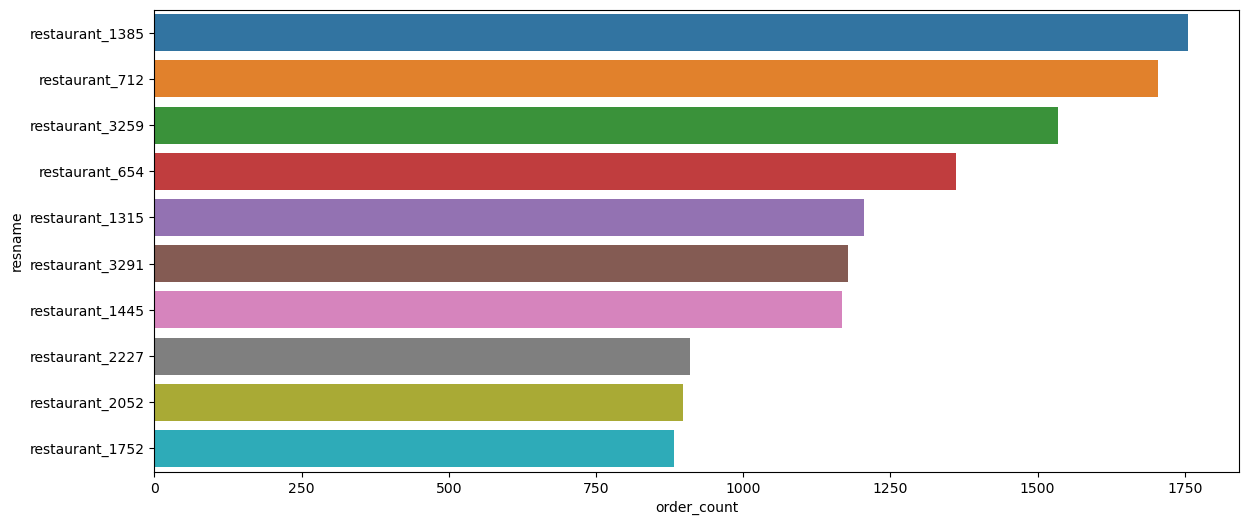

In [14]:
plt.figure(figsize =(14,6))
res = pd.DataFrame(transac_dt[transac_dt.status  == 'COMPLETED'].restaurant_id.value_counts()[:10]).reset_index()
res.columns = ['resname','order_count']
sns.barplot(data = res , y = 'resname' , x = 'order_count')

10 ร้านที่ขายดีที่สุดนั้น มีลักษณะอย่างไร ?

In [15]:
popres = list(res['resname'])

In [16]:
top10res = restuarants[restuarants.restaurant_id .isin( popres)]
top10res

,restaurant_id,main_category,price_range,added_date,total_menu,total_menu_with_photos,total_review,rating
654,restaurant_654,À La Carte,Less than 100,2012-11-24 03:26:09.000,86,65,123,4.0
712,restaurant_712,Thai,ไม่มีข้อมูล,2020-05-06 23:03:13.000,144,50,0,0.0
1315,restaurant_1315,À La Carte,Less than 100,2017-05-20 21:51:10.000,154,42,1,4.0
1385,restaurant_1385,Thai,Less than 100,2016-01-30 22:54:53.000,29,18,14,3.8
1445,restaurant_1445,Café/Coffee Shop,Less than 100,2020-02-06 21:30:20.000,134,134,1,4.0
1752,restaurant_1752,Rice Dish,Less than 100,2019-06-26 03:24:13.000,142,5,7,3.9
2052,restaurant_2052,Fastfood,Less than 100,2020-06-12 03:32:12.000,52,52,0,0.0
2227,restaurant_2227,Café/Coffee Shop,Less than 100,2020-09-24 22:40:13.000,135,135,1,0.0
3259,restaurant_3259,Café/Coffee Shop,Less than 100,2012-11-23 01:02:08.000,118,118,10,3.6
3291,restaurant_3291,Café/Coffee Shop,Less than 100,2020-09-23 20:44:31.000,145,145,0,0.0


<AxesSubplot:xlabel='total_menu', ylabel='Count'>

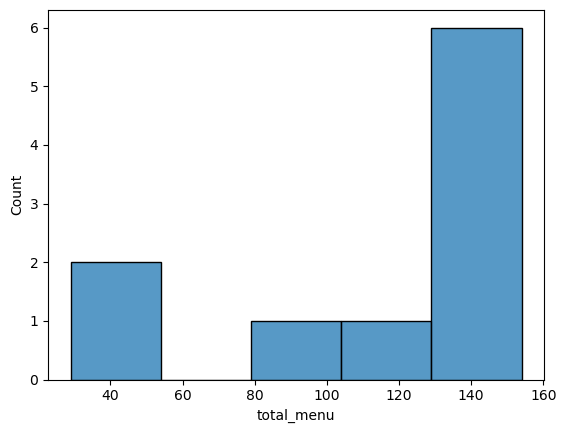

In [17]:
sns.histplot(data = top10res , x = 'total_menu')

<AxesSubplot:xlabel='total_review', ylabel='Count'>

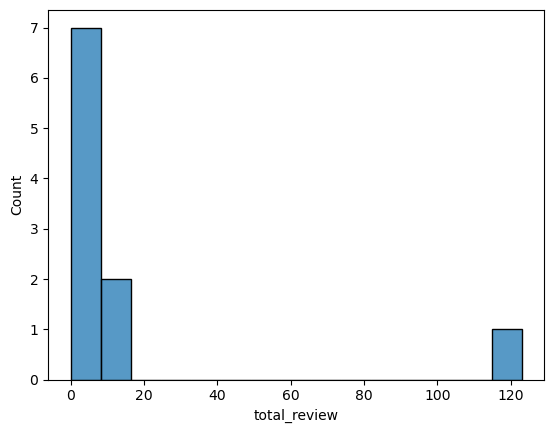

In [18]:
sns.histplot(data = top10res , x = 'total_review')

<AxesSubplot:xlabel='rating', ylabel='count'>

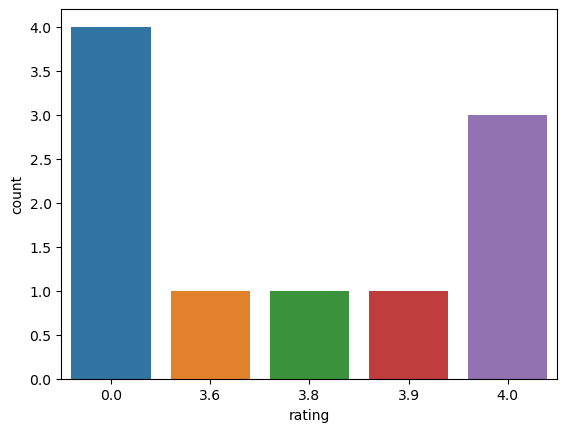

In [19]:
sns.countplot(data = top10res , x = 'rating')

<AxesSubplot:xlabel='main_category', ylabel='count'>

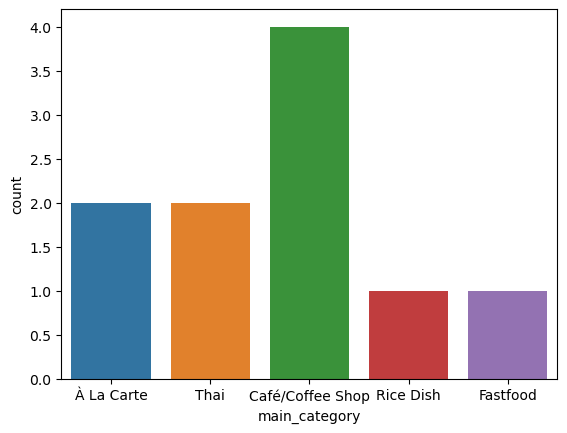

In [20]:
sns.countplot(data = top10res , x = 'main_category')

**Conclusion :** ร้านที่ขายดีส่วนใหญ่นั้น ไม่ได้เกี่ยวกับ rating มากเท่าที่ควร แต่มี 2 ปัจจัย  1. ราคาถูก 2.จำนวนเมนูเยอะ  ดังนั้นจากประโยชน์ตรงนี้เราอาจ encourage ร้านค้าใน แอพ ให้ เพิ่มจำนวนรูปของสินค้า และเพิ่มเมนู เพื่อโอกาสที่จะขายได้มากขึ้น 

# EDA 2 : TIME SINCE REGISTER 
ระยะเวลาที่ user อยู่กับแอพ มีผลต่อการสั่งที่มากขึ้นไหม ?

In [21]:
users.head()

,user_id,first_order_at,first_completed_order_at,created_at
0,user_0,2020-08-24 08:53:02.008,2020-08-24 08:55:43.217,2020-08-18 12:02:03.000
1,user_1,2021-02-28 18:36:53.652,2021-02-28 18:36:53.652,2017-11-02 00:40:32.188
2,user_2,2021-02-24 14:02:03.807,2021-02-24 14:02:03.807,2020-08-20 12:15:07.000
3,user_3,2021-01-21 08:47:45.533,2021-01-21 08:47:45.533,2021-01-21 08:38:07.000
4,user_4,2021-01-19 12:28:27.929,2021-01-19 12:28:27.929,2021-01-19 12:25:59.000


In [22]:
dtusercreate = pd.DataFrame(users.created_at.map(changetime))
dtusercreate.columns = ['dtcreate']
dtusercreate['user_id'] = users.user_id
dtusercreate.head()

daydiff = transac_dt[['user_id','df_createtime']].merge(dtusercreate , on = 'user_id').groupby('user_id')[['df_createtime','dtcreate']].max().reset_index()
daydiff['dayfrombegin'] = (daydiff['df_createtime'] - daydiff['dtcreate']).dt.days
daydiff.head()

,user_id,df_createtime,dtcreate,dayfrombegin
0,user_0,2021-03-02 12:00:26,2020-08-18 12:02:03,195
1,user_1,2021-02-28 18:36:53,2017-11-02 00:40:32,1214
2,user_10,2021-03-13 17:42:21,2020-09-25 18:19:57,168
3,user_100,2021-02-23 00:33:43,2020-08-03 11:11:53,203
4,user_1000,2021-01-06 12:24:06,2017-01-12 23:35:18,1454


In [23]:
userordercount = pd.DataFrame(transac_dt.groupby('user_id').user_id.count())
userordercount.columns = ['ordercount']
order_day = userordercount.reset_index().merge(daydiff[['user_id','dayfrombegin']],on = 'user_id')
order_day.head()

,user_id,ordercount,dayfrombegin
0,user_0,1,195
1,user_1,1,1214
2,user_10,15,168
3,user_100,7,203
4,user_1000,1,1454


In [24]:
order_day.describe().T

,count,mean,std,min,25%,50%,75%,max
ordercount,22757.0,6.112185,10.370252,1.0,1.0,2.0,6.0,342.0
dayfrombegin,22757.0,340.311640,436.048293,0.0,71.0,168.0,355.0,1798.0


<AxesSubplot:xlabel='dayfrombegin', ylabel='Density'>

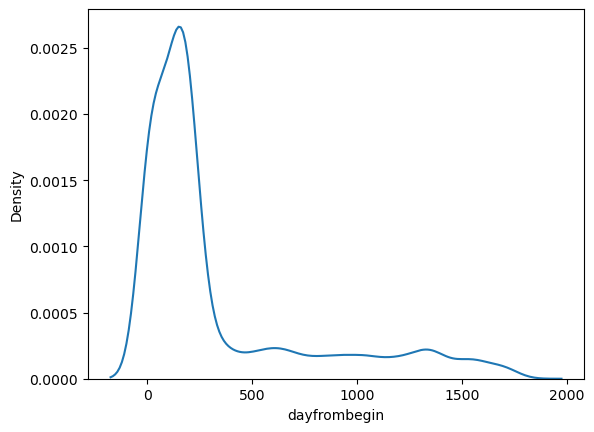

In [25]:
sns.kdeplot(order_day.dayfrombegin)

<AxesSubplot:>

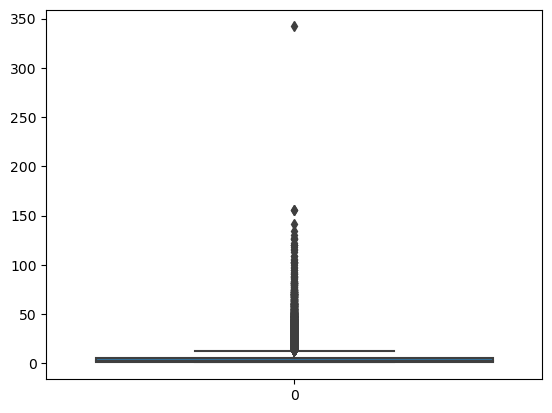

In [26]:
sns.boxplot(data = order_day.ordercount)

<AxesSubplot:xlabel='dayfrombegin', ylabel='ordercount'>

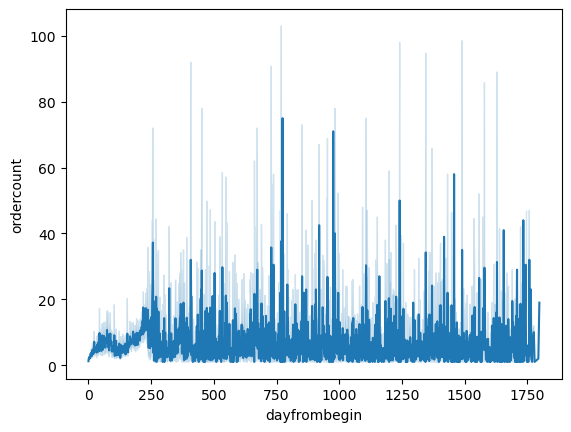

In [27]:
sns.lineplot(data = order_day , x = 'dayfrombegin' , y = 'ordercount')

ดูเหมือนว่าการที่ user  อยู่กับเรามานาน ไม่ได้ทำให้มีการสั่งที่มากขึ้น 
ดังนั้นเราลองมาดูว่า คนที่พึ่งสมัครแอพ ไม่เกิน 30 วัน จะมีแนวโน้มในการสั่งมากขึ้นหรือไม่

<AxesSubplot:xlabel='dayfrombegin', ylabel='ordercount'>

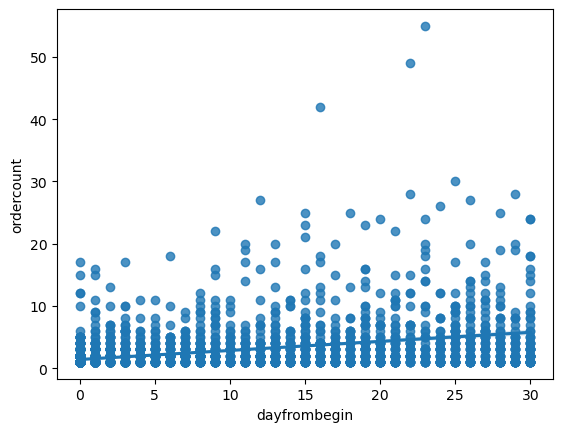

In [28]:
sns.regplot(data = order_day[order_day.dayfrombegin <=30] , x = 'dayfrombegin' , y = 'ordercount')

จากกราฟ ผมคิดว่าผู้ใช้ที่ลงทะเบียนกับแอปพลิเคชันในเดือนนี้มีแนวโน้มที่จะสั่งซื้อมากขึ้น                           
**ข้อสรุป** : เราอาจแบ่ง segment  ของ user ด้วยเวลาที่ลงทะเบียนได้


# EDA3 : ORDER PER WEEK
ความถี่ในการสั่งแต่ละสัปดาห์ มีความเกี่ยวข้อง หรือเป็นเทรนซ้ำๆหรือเปล่า

<AxesSubplot:xlabel='count', ylabel='weekday'>

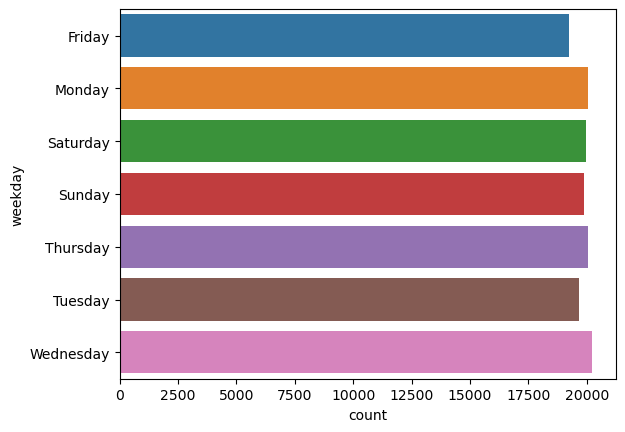

In [29]:
barweekday =  pd.DataFrame(transac_dt.groupby('weekday').weekday.size())
barweekday.rename(columns = {'weekday':'count'}, inplace = True)
barweekday = barweekday.reset_index()
sns.barplot(data = barweekday , y = 'weekday' , x = 'count')

ดูเหมือนว่าจำนวนการสั่งในแต่ละสัปดาห์ ดูจะพอๆกัน

งั้นถ้าเราสุ่มหยิบมาสัก 1 สัปดาห์จะเป็นอย่างไร?

<AxesSubplot:xlabel='count', ylabel='weekday'>

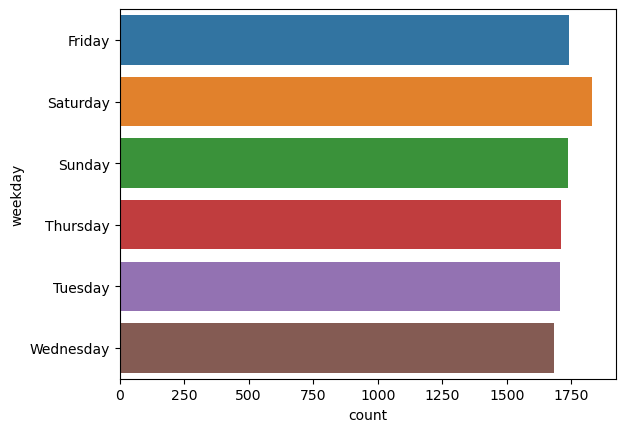

In [30]:
barweekday =  pd.DataFrame(transac_dt[(transac_dt.dt > 20210301)&(transac_dt.dt <= 20210307)].groupby('weekday').weekday.size())
barweekday.rename(columns = {'weekday':'count'}, inplace = True)
barweekday = barweekday.reset_index()
sns.barplot(data = barweekday , y = 'weekday' , x = 'count')

ยังคงไม่แตกต่างกันมาก
**ข้อสรุป** : ตัวแปรวันในแต่ละสัปดาห์อาจไม่มีผลในการทำนายการสั่งเท่าที่ควร

# EDA4 CANCELED

In [31]:
pd.DataFrame(transac_dt.final_food_price.describe()).T

,count,mean,std,min,25%,50%,75%,max
final_food_price,139095.0,108.326757,89.927964,0.0,60.0,80.0,125.0,3580.0


In [32]:
transac_dt[(transac_dt.final_food_price >0) & (transac_dt.status == 'CANCELED')].shape[0]

14129

มี transaction จำนวนมากที่ถูกยกเลิก แต่ยังโดนเก็บค่าอาหาร สิ่งนี้ส่งผลต่อ user experience หรือไม่ ?


<AxesSubplot:xlabel='count', ylabel='status'>

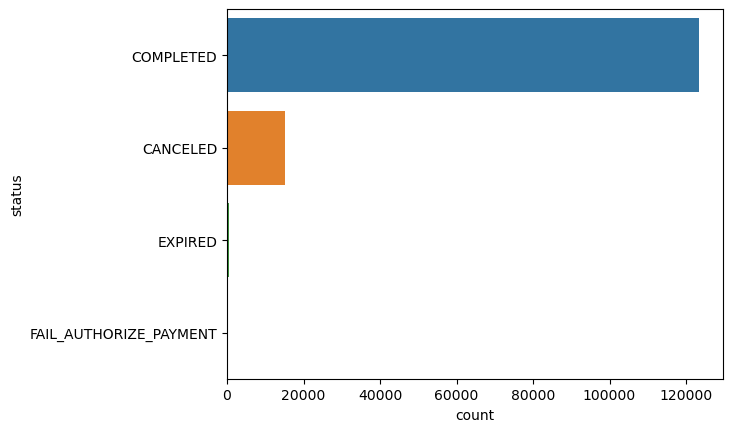

In [33]:
sns.countplot(data = transac_dt , y = 'status')

In [34]:
st  = pd.DataFrame(transac_dt.groupby(['user_id','status']).transaction_id.count()).reset_index().rename(columns = {'transaction_id':'count'})
cancelcount = st[st.status == 'CANCELED']
cancelcount.set_index('user_id')['count'].describe()

count    7284.000000
mean        2.064113
std         2.434338
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       115.000000
Name: count, dtype: float64

115 cancel?

In [35]:
cancelcount[cancelcount['count']==115].user_id

1711    user_11182
Name: user_id, dtype: object

In [36]:
transac_dt[transac_dt.user_id == 'user_11182'].restaurant_id.value_counts()[:3]

restaurant_496     64
restaurant_666     19
restaurant_2363    15
Name: restaurant_id, dtype: int64

ถ้าไม่ใช่ปัญหาจาก user คงจะเป็นปัญหาจากร้านอาหาร เรามาลองดูจำนวนการยกเลิกต่อร้านอาหาร 


In [37]:
transac_dt[transac_dt.status == 'CANCELED'].groupby('restaurant_id').size().sort_values(ascending = False)[:10]

restaurant_id
restaurant_1486    143
restaurant_2554     91
restaurant_2833     84
restaurant_2729     73
restaurant_3259     70
restaurant_2778     66
restaurant_605      64
restaurant_496      64
restaurant_2040     57
restaurant_428      56
dtype: int64

แต่ถ้าดูจำนวนการยกเลิกจากร้านอาหารทั้งหมด restaurant_496 ถูกยกเลิกโดยผู้ใช้คนเดียว ผมคิดว่าน่าจะเป็นปัญหาที่ตัวผู้ใช้ ดังนั้นเราจะผ่านปัญหานี้ไปครับ

ต่อมา เราจะมาวิเคราะห์จำนวนการยกเลิกต่อใช้

In [38]:
cancelcount[cancelcount['count'] >5]

,user_id,status,count
40,user_10024,CANCELED,6
145,user_10096,CANCELED,13
197,user_10133,CANCELED,14
279,user_10191,CANCELED,7
408,user_10279,CANCELED,11
...,...,...,...
29141,user_9784,CANCELED,7
29213,user_9834,CANCELED,9
29278,user_9881,CANCELED,8
29317,user_9903,CANCELED,6


มาดูกันว่าลูกค้าที่ยกเลิกมากกว่า 5 ครั้งยัง ยังเป็น active users ไหม

In [39]:
ng = list(cancelcount[cancelcount['count'] >5].user_id)

*let's assume the customer who order the food in 14 days still active users*

In [40]:
lastdayofcancel = transac_dt[transac_dt.user_id.isin(ng)].groupby('user_id').df_createtime.max().max() - transac_dt[transac_dt.user_id.isin(ng)].groupby('user_id').df_createtime.max()
s = lastdayofcancel.dt.days 
s[s>14].shape[0] / s.shape[0]

0.17615176151761516

หมายความว่า 17 % ของผู้ใช้ที่มีสถานะ == CANCELED มากกว่า 5 ครั้งไม่ใช่ผู้ใช้ที่ใช้งานอยู่

**ข้อสรุป** : เราควรเก็บปัญหานี้ไว้เพื่อพัฒนาต่อเพราะ เห็นได้ว่า จำนวนครั้งที่ cancel มาก หมายถึง user experience ที่ลดลง แต่เนื่องจาก ลูกค้าที่ยกเลิกมากกว่า 5 ครั้ง มีจำนวนน้อยเมื่อเทียบกับลูกค้าทั้งหมด จึงไม่ขอนำมาพิจารณาในการทำ model

# **DATA PREPARATION**

เราจะแบ่งข้อมูลออกเป็น 2 ส่วน 

1.ข้อมูลทุกอย่างถึงวันที่ 22 เดือน 3

2.ข้อมูลวันที่ 23 24 25 เดือน 3 

In [41]:
def cutoffdata(df,start,day):
    invoice = df[df.dt <= start]
    invoidnext3 = df[(df.dt >=  start+1) &(df.dt <= start+3)]
    return (invoice , invoidnext3)
'''
nextpurchasedf คำนวนว่า หากเรา cutoff วันที่ 22 จะใช้เวลากี่วัน ถึงจะซื้อภายใน 23 24 25 
แน่นอนว่า จะมีบางคน ที่ไม่ได้ซื้อและมี null เกิดขึ้น
'''
def nextpurchasedf(df,start,day):
    inv,inv3 = cutoffdata(df,start,day)
    lastdaypurchase = inv.groupby('user_id').df_createtime.max()
    firstpurchaseofnext3 = inv3.groupby('user_id').df_createtime.min()
    nextpurchase = pd.DataFrame((firstpurchaseofnext3 - lastdaypurchase).dt.days)
    nextpurchase = nextpurchase.reset_index().rename(columns = {'df_createtime':'nextpurchaseday'}).sort_values(by = 'nextpurchaseday')
    nextpurchase.fillna(99999,inplace = True)
    ## จัดการ null 
    return nextpurchase

In [42]:
fooinvoice = cutoffdata(transac_dt,20210322,3)[0]
nextpurchase = nextpurchasedf(transac_dt,20210322,3)
display(fooinvoice.head(3))

,transaction_id,created_at,dt,user_id,restaurant_id,status,distance,final_food_price,discount_amount,completed_at,delivery_fee,df_createtime,weekday
222,transaction_1105,2021-03-22 09:43:39.548,20210322,user_7322,restaurant_1385,COMPLETED,831.0,50.0,NaN,2021-03-22 09:52:36.719,0.0,2021-03-22 09:43:39,Monday
223,transaction_1106,2021-03-22 14:52:35.619,20210322,user_16010,restaurant_461,COMPLETED,6201.0,100.0,NaN,2021-03-22 15:10:53.997,0.0,2021-03-22 14:52:35,Monday
224,transaction_1107,2021-03-22 11:46:26.284,20210322,user_1819,restaurant_486,COMPLETED,5034.0,65.0,NaN,2021-03-22 12:06:14.775,0.0,2021-03-22 11:46:26,Monday


จากการeda ทำให้เราเลือกเพียงบางตัวมาใช้งานต่อ

In [43]:
invoice = fooinvoice.drop(['created_at','discount_amount','delivery_fee','weekday','completed_at'],axis = 1)

In [44]:
invoice.head()

,transaction_id,dt,user_id,restaurant_id,status,distance,final_food_price,df_createtime
222,transaction_1105,20210322,user_7322,restaurant_1385,COMPLETED,831.0,50.0,2021-03-22 09:43:39
223,transaction_1106,20210322,user_16010,restaurant_461,COMPLETED,6201.0,100.0,2021-03-22 14:52:35
224,transaction_1107,20210322,user_1819,restaurant_486,COMPLETED,5034.0,65.0,2021-03-22 11:46:26
225,transaction_1108,20210322,user_19560,restaurant_753,COMPLETED,1776.0,50.0,2021-03-22 13:15:38
226,transaction_1109,20210322,user_6532,restaurant_1697,COMPLETED,1884.0,55.0,2021-03-22 07:35:13


In [45]:
invoice.isnull().sum()

transaction_id      0
dt                  0
user_id             0
restaurant_id       0
status              0
distance            0
final_food_price    0
df_createtime       0
dtype: int64

In [46]:
display(nextpurchase.head())

,user_id,nextpurchaseday
6896,user_16203,0.0
14075,user_22665,0.0
11068,user_1996,0.0
4490,user_14038,0.0
20102,user_7609,0.0


In [47]:
nextpurchase.isnull().sum()

user_id            0
nextpurchaseday    0
dtype: int64

# Feature Engineering

**1.RFM ANALYSIS**

เราจะใช้ RFM analysis ในการสร้าง feature ใหม่ของเรา คือ

* recency  ความเป็นปัจจุบัน
* frequency ความถี่ในการซื้อ
* monetary รายได้ที่เราได้ ( ในส่วนนี้ ทางแอพ ไม่ได้รายได้จากค่าอาหารโดยตรงแต่รายได้ก็มาจากการหัก ค่า gp จากค่าอาหาร ดังนั้นจึงถือว่าในส่วนนี้ใช้แทนกันได้ )

โดยเราจะแบ่ง segment ของลูกค้า ออกเป็นสอง เกรด คือ high-value กับ low-value จากการใช้ kmeans ในการcluster กลุ่ม ออกเป็น 4 กลุ่ม ซึ่งตัวเลข 4 นั้น ได้มาจากการ ทำ Elbow method แล้ว

สาเหตุที่แบ่งเกรดแค่ high  กับ low  เนื่องจากว่าการ predict ของเรานั้นแค่ 3 วัน ทำให้ หากมี middle เข้ามาด้วยอาจจะเกิด noise ต่อโมเดล


**RECENCY**

In [48]:
last = pd.DataFrame(invoice.groupby('user_id').df_createtime.max()).reset_index()
last.columns = ['user_id','lastpurchasedate']
last['Recency'] = (last.lastpurchasedate.max() - last.lastpurchasedate).dt.days
nextpurchase = nextpurchase.merge(last[['user_id','Recency']] , on = 'user_id')
nextpurchase.head()

,user_id,nextpurchaseday,Recency
0,user_16203,0.0,0
1,user_22665,0.0,0
2,user_1996,0.0,0
3,user_14038,0.0,0
4,user_7609,0.0,0


<AxesSubplot:xlabel='Recency', ylabel='Density'>

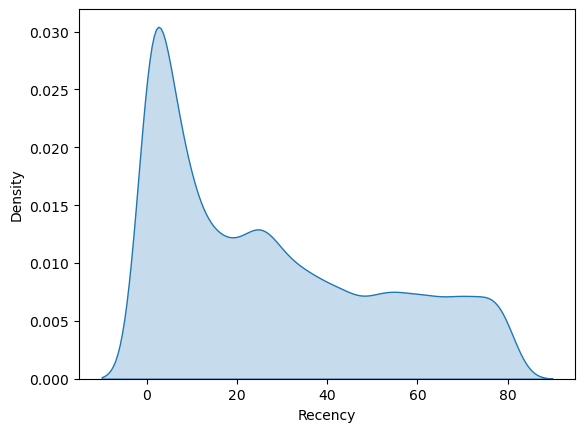

In [49]:
sns.kdeplot(nextpurchase.Recency,shade = True)

In [50]:
 from sklearn.cluster import KMeans

In [51]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(nextpurchase[['Recency']])
nextpurchase['RecencyCluster'] = kmeans.predict(nextpurchase[['Recency']])
nextpurchase = order_cluster(nextpurchase, 'Recency', 'RecencyCluster', False)
nextpurchase.head()

,user_id,nextpurchaseday,Recency,RecencyCluster
0,user_16203,0.0,0,3
1,user_22665,0.0,0,3
2,user_1996,0.0,0,3
3,user_14038,0.0,0,3
4,user_7609,0.0,0,3


 **Frequency**

In [52]:
frequence  = pd.DataFrame(invoice.groupby('user_id').df_createtime.count()).reset_index()
frequence.columns = ['user_id', 'frequency']
nextpurchase = nextpurchase.merge(frequence, on='user_id')
nextpurchase.head()

,user_id,nextpurchaseday,Recency,RecencyCluster,frequency
0,user_16203,0.0,0,3,3
1,user_22665,0.0,0,3,21
2,user_1996,0.0,0,3,34
3,user_14038,0.0,0,3,10
4,user_7609,0.0,0,3,7


In [53]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(nextpurchase[['frequency']])
nextpurchase['frequencyCluster'] = kmeans.predict(nextpurchase[['frequency']])
nextpurchase = order_cluster(nextpurchase, 'frequency', 'frequencyCluster', False)
nextpurchase.head()

,user_id,nextpurchaseday,Recency,RecencyCluster,frequency,frequencyCluster
0,user_16203,0.0,0,3,3,3
1,user_7609,0.0,0,3,7,3
2,user_15276,0.0,0,3,1,3
3,user_7870,0.0,0,3,6,3
4,user_11858,0.0,0,3,1,3


**Revenue**

In [54]:
revenue  = pd.DataFrame(invoice.groupby('user_id').final_food_price.sum()).reset_index()
revenue.columns = ['user_id', 'revenue']
nextpurchase = nextpurchase.merge(revenue, on='user_id')
nextpurchase.head()

,user_id,nextpurchaseday,Recency,RecencyCluster,frequency,frequencyCluster,revenue
0,user_16203,0.0,0,3,3,3,354.0
1,user_7609,0.0,0,3,7,3,429.0
2,user_15276,0.0,0,3,1,3,40.0
3,user_7870,0.0,0,3,6,3,750.0
4,user_11858,0.0,0,3,1,3,154.0


In [55]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(nextpurchase[['revenue']])
nextpurchase['revenueCluster'] = kmeans.predict(nextpurchase[['revenue']])
nextpurchase = order_cluster(nextpurchase, 'revenue', 'revenueCluster', True)
nextpurchase.head()

,user_id,nextpurchaseday,Recency,RecencyCluster,frequency,frequencyCluster,revenue,revenueCluster
0,user_16203,0.0,0,3,3,3,354.0,0
1,user_7609,0.0,0,3,7,3,429.0,0
2,user_15276,0.0,0,3,1,3,40.0,0
3,user_7870,0.0,0,3,6,3,750.0,0
4,user_11858,0.0,0,3,1,3,154.0,0


In [56]:
nextpurchase.head()

,user_id,nextpurchaseday,Recency,RecencyCluster,frequency,frequencyCluster,revenue,revenueCluster
0,user_16203,0.0,0,3,3,3,354.0,0
1,user_7609,0.0,0,3,7,3,429.0,0
2,user_15276,0.0,0,3,1,3,40.0,0
3,user_7870,0.0,0,3,6,3,750.0,0
4,user_11858,0.0,0,3,1,3,154.0,0


In [57]:
nextpurchase['score'] = nextpurchase['RecencyCluster']+nextpurchase['frequencyCluster']+nextpurchase['revenueCluster']

In [58]:
nextpurchase.groupby('score')[['Recency','frequency','revenue']].mean()

,Recency,frequency,revenue
score,,,
2,64.800000,9.600000,722.200000
3,69.552494,1.776247,198.866079
4,46.570074,2.783983,305.368952
5,22.439394,6.095471,564.703661
6,5.729541,8.899202,945.653406
7,4.964346,11.112054,2315.901290
8,4.444444,13.888889,6766.555556


we will choose 6-7-8 be our best 

In [59]:
nextpurchase['segment'] = 'Low'
nextpurchase.loc[nextpurchase.score >= 6,['segment']] = 'High'

In [60]:
nextpurchase.head()

,user_id,nextpurchaseday,Recency,RecencyCluster,frequency,frequencyCluster,revenue,revenueCluster,score,segment
0,user_16203,0.0,0,3,3,3,354.0,0,6,High
1,user_7609,0.0,0,3,7,3,429.0,0,6,High
2,user_15276,0.0,0,3,1,3,40.0,0,6,High
3,user_7870,0.0,0,3,6,3,750.0,0,6,High
4,user_11858,0.0,0,3,1,3,154.0,0,6,High


**2.ORDER TIME AVERAGE**

ตัวแปรนี้ได้มาจากการทำ EDA1 และ EDA2 โดยเราจะแบ่ง cluster คล้ายกับ RFM แต่จะใช้เป็นการกำหนดช่วงที่อยากได้แทน การใช้ kmeans
โดยจะมี feature ใหม่ 3 อันคือ 

interval  = ระยะห่างระหว่าง 2 ออร์เดอร์ ล่าสุด (วัน)

intervalcluster = clustter ของ interval แบ่งตามassumption ใน EDA 1

isjustregister = ผู้ใช้ได้สมัครแอพภายใน 30 วันหรือไม่ (yes,no)

In [61]:
t_all = invoice.groupby('user_id').df_createtime.agg(['max','min','count']).reset_index()
daydiff = invoice[['user_id','df_createtime']].merge(dtusercreate , on = 'user_id').groupby('user_id')[['df_createtime','dtcreate']].max().reset_index()

daydiff['dayfrombegin'] = (daydiff['df_createtime'] - daydiff['dtcreate']).dt.days
t_all = t_all.merge(daydiff[['user_id' , 'dayfrombegin']] , on = 'user_id')
t_all['av_day'] = ((t_all['max'] - t_all['min']).dt.days)/(t_all['count'])
t_all['interval'] = ((t_all['max'] - t_all['min']).dt.days)


In [62]:
t_all['intervalcluster'] = 'Low'
t_all.loc[((t_all["count"] > 1 ) & (t_all.interval <7)),'intervalcluster'] = 'High'
t_all.loc[(t_all["count"]==1 ),'intervalcluster'] = 'Zero'
t_all['isjustregister'] = 'No'
t_all.loc[t_all.dayfrombegin < 30,'isjustregister'] = 'Yes'
t_all

,user_id,max,min,count,dayfrombegin,av_day,interval,intervalcluster,isjustregister
0,user_0,2021-03-02 12:00:26,2021-03-02 12:00:26,1,195,0.000000,0,Zero,No
1,user_1,2021-02-28 18:36:53,2021-02-28 18:36:53,1,1214,0.000000,0,Zero,No
2,user_10,2021-03-13 17:42:21,2021-01-04 11:30:27,15,168,4.533333,68,Low,No
3,user_100,2021-02-23 00:33:43,2021-01-27 15:19:18,7,203,3.714286,26,Low,No
4,user_1000,2021-01-06 12:24:06,2021-01-06 12:24:06,1,1454,0.000000,0,Zero,No
...,...,...,...,...,...,...,...,...,...
22187,user_9995,2021-02-02 17:47:28,2021-02-02 17:47:28,1,1310,0.000000,0,Zero,No
22188,user_9996,2021-01-02 12:57:32,2021-01-01 18:00:05,4,512,0.000000,0,High,No
22189,user_9997,2021-03-13 17:57:37,2021-03-13 17:57:37,1,0,0.000000,0,Zero,Yes
22190,user_9998,2021-02-16 11:33:26,2021-02-16 11:33:26,1,25,0.000000,0,Zero,Yes


**3.TIME UNTIL ORDER AGAIN**

feature นี้นั้นคือเวลาเฉลี่ยของแต่ละร้านที่ลูกค้ากลับมาซื้ออีกครั้ง พราะจากการสังเกตพบว่ามีลูกค้าจำนวนมาก สั่งอาหารอีกครั้งในเวลาอันสั้น อาจตั้งสมมุติฐานได้ว่า เมื่อสั่งแล้วเกิดความประทับใจและอยากสั่งอีกครั้งในวันต่อมา หรือ 3 วันต่อมา ดังนั้นเราจะสร้างfeature ชื่อ  eatagain เป็นเวลาเฉลี่ยที่ลูกค้าส่วนใหญ่กลับมากินที่ร้านเดิมอีกครั้ง
และเก็บข้อมูลว่าจากข้อมูลทั้งหมด ร้านล่าสุดที่ลูกค้ากินคืออะไร ยกตัวอย่างเช่นและหากสมมุติว่า กินในวันที่ 25 และร้านค้านั้น มีเวลาเฉลี่ยที่ลูกค้าคนอื่นๆกลับมากินซ้ำน้อยกว่า 3 วัน นั่นแสดงว่า ลูกค้าคนนี้นั้นก็จะมีแนวโน้มกลับมากินที่ร้านเดิมอีกภายใน 3 วัน

In [63]:
d = {}
dd = {}
eatagain = {}

def resmani(row):
    res = row.restaurant_id
    use = row.user_id
    if res not in d.keys():
        d[res] = {}
        dd[res] = {}
    if use not in d[res].keys():
        d[res][use] = []
        dd[res][use] = -1
    d[res][use].append(row.df_createtime)
    
def manipulateres(dfa):
    dfa.apply(resmani ,axis = 1)
    for i in d.keys():
        for j in d[i].keys():
            if(len(d[i][j]) != 1):
                k = sorted(d[i][j])
                dd[i][j] = (k[1]-k[0]).days
    cnt = 0
    for i in dd.keys():
        if (max(list(dd[i].values()))) == -1:
            eatagain[i] = 9999
        else:
            n = 0
            s = 0
            for j in (list(dd[i].values())):
                if j!=-1:
                    n+=1
                    s+=j
            eatagain[i] = s/n
    lasttime = pd.DataFrame(dfa.groupby('user_id').df_createtime.idxmax())
    eatlast = lasttime.df_createtime.map(lambda b: dfa.loc[b,'restaurant_id']).to_dict()
    eatagaindfa = pd.DataFrame(pd.Series(eatagain)).reset_index()
    eatagaindfa.columns = ['reslast','eatagain']
    #display(eatagaindfa)
    eatlastdfa = pd.DataFrame(pd.Series(eatlast)).reset_index()
    eatlastdfa.columns = ['user_id','reslast']
    #display(eatlastdfa)
    
    return    eatlastdfa.merge(eatagaindfa ,on = 'reslast')

eatfea = manipulateres(invoice) 


In [64]:
eatfea.head()
#reslast  ร้านที่ลูกค้ามากินล่าสุด
#eatagain  เวลาเฉลี่ยที่ลูกค้ามากินร้านนี้ซ้ำ (วัน)

,user_id,reslast,eatagain
0,user_0,restaurant_931,13.3125
1,user_10464,restaurant_931,13.3125
2,user_10840,restaurant_931,13.3125
3,user_11783,restaurant_931,13.3125
4,user_13978,restaurant_931,13.3125


In [65]:
dum  = nextpurchase.copy()
dum = dum.merge(t_all[['user_id','dayfrombegin','av_day','interval','intervalcluster','isjustregister']] , on = 'user_id')
dum['eva'] = 1
dum.loc[dum.nextpurchaseday > 2 , 'eva'] = 0
# ซื้อมากกว่า 3 วันมีค่าเป็น 0 (นับ 0 เป็นวันที่ 1 จึงใช้ > 2 )

In [66]:
dum = dum.merge(eatfea.drop(['reslast'],axis = 1) , on = 'user_id')

In [67]:
bftrain = pd.get_dummies(dum.drop(['user_id','nextpurchaseday'],axis = 1))

In [68]:
bftrain.head()

,Recency,RecencyCluster,frequency,frequencyCluster,revenue,revenueCluster,score,dayfrombegin,av_day,interval,eva,eatagain,segment_High,segment_Low,intervalcluster_High,intervalcluster_Low,intervalcluster_Zero,isjustregister_No,isjustregister_Yes
0,0,3,3,3,354.0,0,6,151,0.333333,1,1,3.666667,1,0,1,0,0,1,0
1,0,3,7,3,429.0,0,6,186,8.571429,60,1,12.074074,1,0,0,1,0,1,0
2,0,3,1,3,40.0,0,6,0,0.000000,0,1,11.244444,1,0,0,0,1,0,1
3,0,3,6,3,750.0,0,6,778,12.666667,76,1,13.760000,1,0,0,1,0,1,0
4,0,3,1,3,154.0,0,6,0,0.000000,0,1,7.875000,1,0,0,0,1,0,1


# MODEL SELECTION

In [69]:
from sklearn.metrics import roc_auc_score , f1_score , recall_score , precision_score , accuracy_score

In [70]:
X = bftrain.drop(['eva'],axis = 1)
y = bftrain['eva']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.33,random_state = 42)

**LogisticRegression**

In [71]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter = 1000, random_state = 42)
clf.fit(x_train, y_train)
yhat = clf.predict(x_test)
modelist = []
modelist.append(pd.DataFrame(pd.Series({'roc_auc_score': str(roc_auc_score(yhat,y_test)),
'f1_score ':str(f1_score(yhat,y_test)),
'recall_score ':str(recall_score(yhat,y_test)),
'precision_score ':str(precision_score(yhat,y_test)),
'accuracy_score ':str(accuracy_score(yhat,y_test))})).rename(columns = {0 :'logistic_score'}))

**KNeighborsClassifier**

In [72]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train,y_train)

y_pred = knn.predict(x_test)
modelist.append(pd.DataFrame(pd.Series({'roc_auc_score': str(roc_auc_score(y_pred,y_test)),
'f1_score ':str(f1_score(y_pred,y_test)),
'recall_score ':str(recall_score(y_pred,y_test)),
'precision_score ':str(precision_score(y_pred,y_test)),
'accuracy_score ':str(accuracy_score(y_pred,y_test))})).rename(columns = {0 :'knn_score'}))

C:\Users\PHUPHA\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


**DecisionTreeClassifier**

In [73]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()
dec_tree.fit(x_train,y_train)
y_pred = dec_tree.predict(x_test)
modelist.append(pd.DataFrame(pd.Series({'roc_auc_score': str(roc_auc_score(y_pred,y_test)),
'f1_score ':str(f1_score(y_pred,y_test)),
'recall_score ':str(recall_score(y_pred,y_test)),
'precision_score ':str(precision_score(y_pred,y_test)),
'accuracy_score ':str(accuracy_score(y_pred,y_test))})).rename(columns = {0 :'decisiontree_score'}))

**RandomForestClassifier**

In [74]:
from sklearn.ensemble import RandomForestClassifier
rand_forest = RandomForestClassifier(n_estimators=100, random_state=42)
rand_forest.fit(x_train,y_train)
y_pred = rand_forest.predict(x_test)
modelist.append(pd.DataFrame(pd.Series({'roc_auc_score': str(roc_auc_score(y_pred,y_test)),
'f1_score ':str(f1_score(y_pred,y_test)),
'recall_score ':str(recall_score(y_pred,y_test)),
'precision_score ':str(precision_score(y_pred,y_test)),
'accuracy_score ':str(accuracy_score(y_pred,y_test))})).rename(columns = {0 :'randomforestscore'}))

**GaussianNB**

In [75]:
from sklearn.naive_bayes import GaussianNB
naive_bayes = GaussianNB()
naive_bayes.fit(x_test,y_test)
y_pred = naive_bayes.predict(x_test)


modelist.append(pd.DataFrame(pd.Series({'roc_auc_score': str(roc_auc_score(y_pred,y_test)),
'f1_score ':str(f1_score(y_pred,y_test)),
'recall_score ':str(recall_score(y_pred,y_test)),
'precision_score ':str(precision_score(y_pred,y_test)),
'accuracy_score ':str(accuracy_score(y_pred,y_test))})).rename(columns = {0 :'gaussiannb_score'}))

# MODEL EVALUATION

In [76]:
pd.concat(modelist,axis = 1)

,logistic_score,knn_score,decisiontree_score,randomforestscore,gaussiannb_score
roc_auc_score,0.8292139131773887,0.6514912572564999,0.7180459037898125,0.811031197223926,0.6603292649547129
f1_score,0.6151645207439199,0.13473684210526315,0.4731457800511509,0.5912305516265913,0.4772079772079772
recall_score,0.6825396825396826,0.3516483516483517,0.4648241206030151,0.6470588235294118,0.3284313725490196
precision_score,0.5598958333333334,0.08333333333333333,0.4817708333333333,0.5442708333333334,0.8723958333333334
accuracy_score,0.9632714363735664,0.9438831239759694,0.9437465865647188,0.9605406881485528,0.899781540141999


**เราจะเลือก logistic regression model เพราะมี f1 score สูงที่สุด แต่เราจะเพิ่มประสิทธิภาพด้วยการตัด feature  ที่ไม่จำเป็นบางอย่างออก**

<AxesSubplot:>

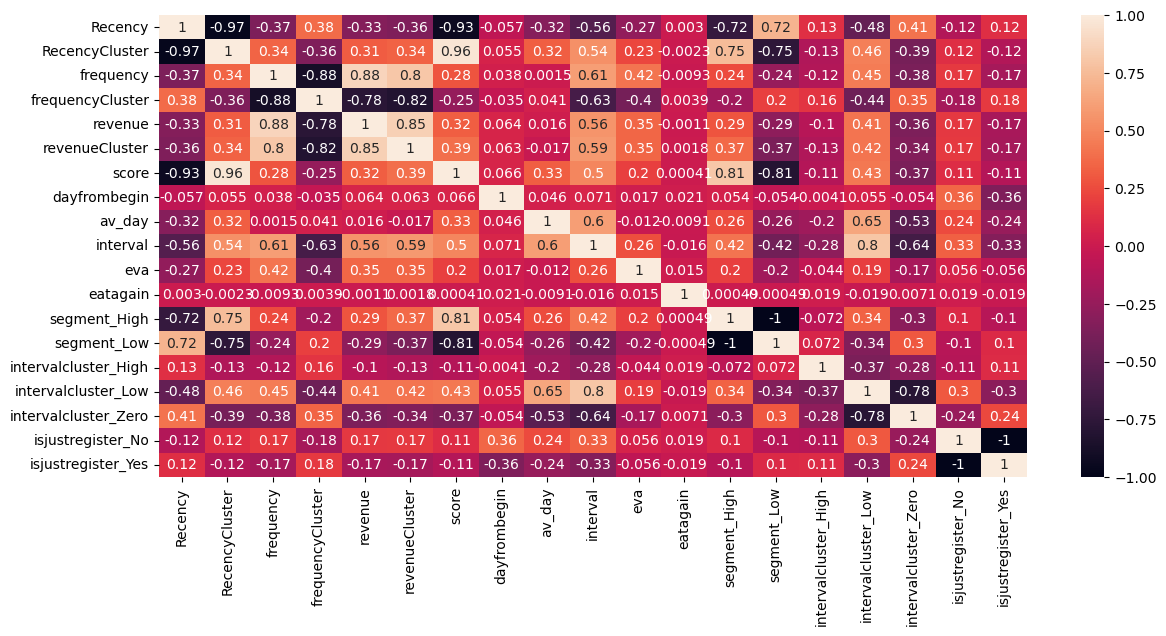

In [77]:
plt.figure(figsize = (14,6))
sns.heatmap(bftrain.corr(),annot = True)

In [78]:
bftrain.head()

,Recency,RecencyCluster,frequency,frequencyCluster,revenue,revenueCluster,score,dayfrombegin,av_day,interval,eva,eatagain,segment_High,segment_Low,intervalcluster_High,intervalcluster_Low,intervalcluster_Zero,isjustregister_No,isjustregister_Yes
0,0,3,3,3,354.0,0,6,151,0.333333,1,1,3.666667,1,0,1,0,0,1,0
1,0,3,7,3,429.0,0,6,186,8.571429,60,1,12.074074,1,0,0,1,0,1,0
2,0,3,1,3,40.0,0,6,0,0.000000,0,1,11.244444,1,0,0,0,1,0,1
3,0,3,6,3,750.0,0,6,778,12.666667,76,1,13.760000,1,0,0,1,0,1,0
4,0,3,1,3,154.0,0,6,0,0.000000,0,1,7.875000,1,0,0,0,1,0,1


In [79]:
X = bftrain.drop(['eva','dayfrombegin','score','revenue','interval'],axis = 1)
y = bftrain['eva']
# ตัด feature 'dayfrombegin','score','revenue','interval'

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.33,random_state = 42)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter = 1000 , random_state = 42)
clf.fit(x_train, y_train)
yhat = clf.predict(x_test)
pd.DataFrame(pd.Series({'roc_auc_score': str(roc_auc_score(yhat,y_test)),
'f1_score ':str(f1_score(yhat,y_test)),
'recall_score ':str(recall_score(yhat,y_test)),
'precision_score ':str(precision_score(yhat,y_test)),
'accuracy_score ':str(accuracy_score(yhat,y_test))})).rename(columns = {0 :'logistic_score'})


,logistic_score
roc_auc_score,0.8200223568253308
f1_score,0.6134453781512607
recall_score,0.6636363636363637
precision_score,0.5703125
accuracy_score,0.9623156744948116


หลังจาก เลือก feature ที่มีประโยชน์แล้ว จะ เห็นได้ว่า ค่าmetrics  ต่างๆเพิ่มขึ้นอย่างเห็นได้ชัด